# STAT0032 Group 12 Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from scipy.stats import norm
import statsmodels.api as sm
import seaborn as sns

## Importing data

In [2]:
# Import data
hour_data = pd.read_csv("data/hour.csv")
day_data = pd.read_csv("data/day.csv")

## Checks that '*day.csv*' can be constructed from  '*hour.csv*'

In [3]:
# Collapse hour data at the day level
hour_data_collapsed = hour_data.groupby(['dteday'])[['temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']].agg(['mean', 'sum']).reset_index()

# Clean index names
hour_data_collapsed.columns = hour_data_collapsed.columns.to_flat_index()
for i in range(1, len(hour_data_collapsed.columns)):
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i]:hour_data_collapsed.columns[i][0] + '_' + hour_data_collapsed.columns[i][1]}, axis=1)
hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[0] : 'dteday'}, axis=1)

# Keep only variables of interest and rename
hour_data_collapsed = hour_data_collapsed.drop(['temp_sum', 'atemp_sum', 'windspeed_sum', 'casual_mean', 'registered_mean', 'cnt_mean'], axis=1)

for i in range(1, len(hour_data_collapsed.columns)):
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i].removesuffix('_mean')}, axis=1)
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i].removesuffix('_sum')}, axis=1)
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i] + '_collapsed'}, axis=1)

# Merge collapsed hour data with day data
merged_data = pd.merge(day_data, hour_data_collapsed, on='dteday')
columns_to_check = ['temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']
for c in columns_to_check:
    col = c + '_check'
    merged_data[col] = merged_data[c] - merged_data[c + '_collapsed']

# Assert checked versions are zero
for c in columns_to_check:
    col = c + '_check'
    assert merged_data[col].min() > -0.00001
    assert merged_data[col].max() < 0.00001

## Pre-processing

In [4]:
# Spring and summer only
peak_evenings = hour_data.copy()
peak_evenings = peak_evenings[peak_evenings.season.isin([1, 2])]

# Defining evening peak times
peak_evenings = peak_evenings[peak_evenings.workingday==1]
peak_evenings = peak_evenings[peak_evenings.hr.isin([16,17,18,19])]

## Histograms

In [5]:
# Collapse at the daily level
peak_evenings_daily = peak_evenings.copy()
peak_evenings_daily = peak_evenings_daily.groupby(['dteday', 'season'])[['cnt']].agg(['sum'])
peak_evenings_daily.columns=peak_evenings_daily.columns.droplevel(0)
peak_evenings_daily.reset_index(inplace=True)

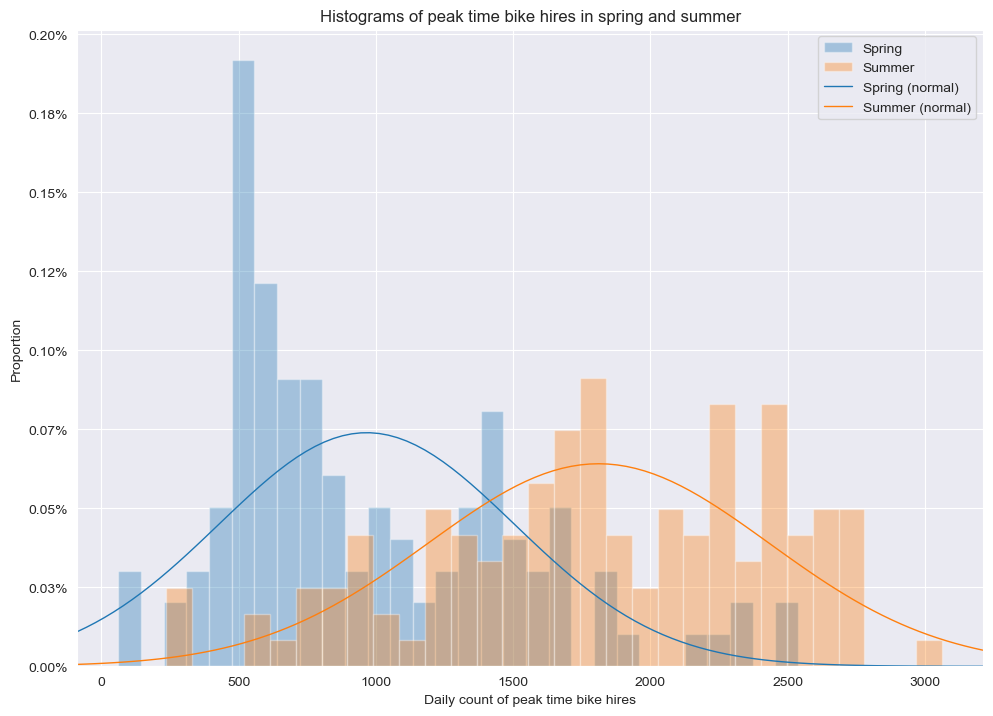

In [6]:
# Setup normal distributions
mu_spring, std_spring = norm.fit(peak_evenings_daily['sum'][peak_evenings_daily.season==1])
mu_summer, std_summer = norm.fit(peak_evenings_daily['sum'][peak_evenings_daily.season==2])

# Histogram plot
fig, ax = plt.subplots(figsize=(11.69,8.27))
ax.hist(peak_evenings_daily['sum'][peak_evenings_daily.season==1], alpha=0.35, density=True, bins=30, label='Spring')
ax.hist(peak_evenings_daily['sum'][peak_evenings_daily.season==2], alpha=0.35, density=True, bins=30, label='Summer')

# Plot the normal distributions
x_min, x_max = plt.xlim()
x = np.linspace(x_min, x_max, 100)
p_spring = norm.pdf(x, mu_spring, std_spring)
p_summer = norm.pdf(x, mu_summer, std_summer)
plt.plot(x, p_spring, 'C0', linewidth=1, label='Spring (normal)')
plt.plot(x, p_summer, 'C1', linewidth=1, label = 'Summer (normal)')

# Plotting setup
plt.margins(x=0)
ax.legend(loc = 'upper right')
ax.set_ylabel('Proportion')
ax.set_xlabel('Daily count of peak time bike hires')
ax.set_title('Histograms of peak time bike hires in spring and summer')
ax.yaxis.set_major_formatter(tick.PercentFormatter(xmax=1, decimals=2))
fig.savefig('plots/Peak times combined histograms.png')

The histogram above shows that neither of the two distributions appear to follow a normal distribution, nor do they seem to follow similar distributions.

## Q-Q Plots

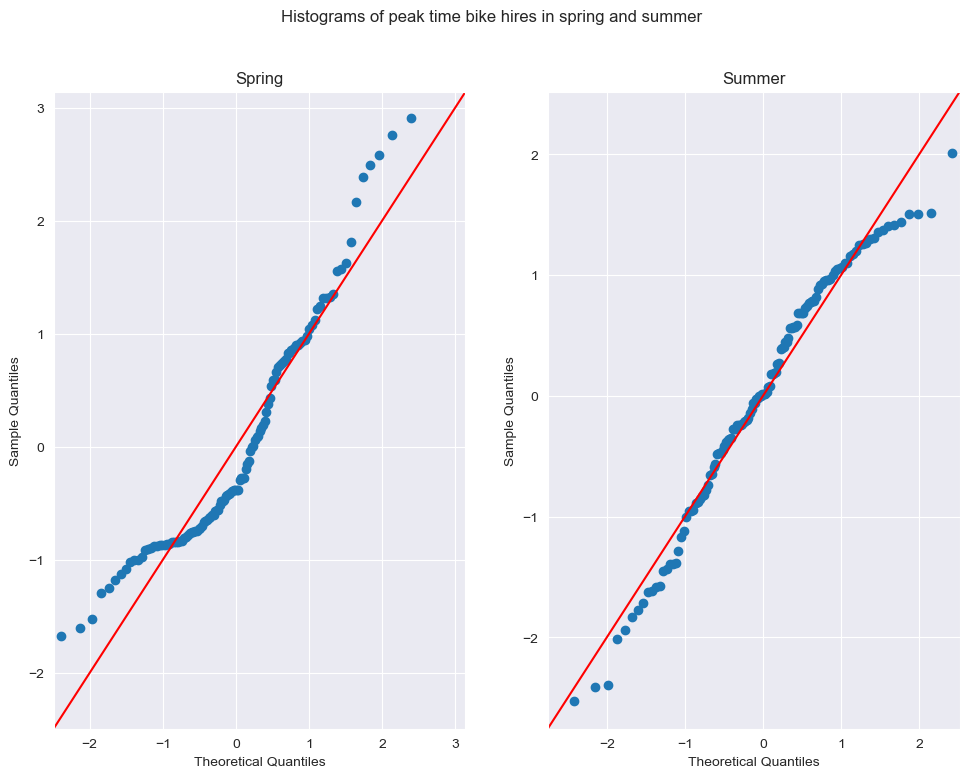

In [7]:
fig, (ax0, ax1)= plt.subplots(ncols=2, figsize=(11.69,8.27))
sm.qqplot(peak_evenings_daily['sum'][peak_evenings_daily.season==1], line='45', fit=True, ax = ax0)
ax0.set_title('Spring')
sm.qqplot(peak_evenings_daily['sum'][peak_evenings_daily.season==2], line='45', fit=True, ax = ax1)
ax1.set_title('Summer')
fig.suptitle('Histograms of peak time bike hires in spring and summer')
fig.savefig('plots/QQ plots.png')

## Other descriptive charts

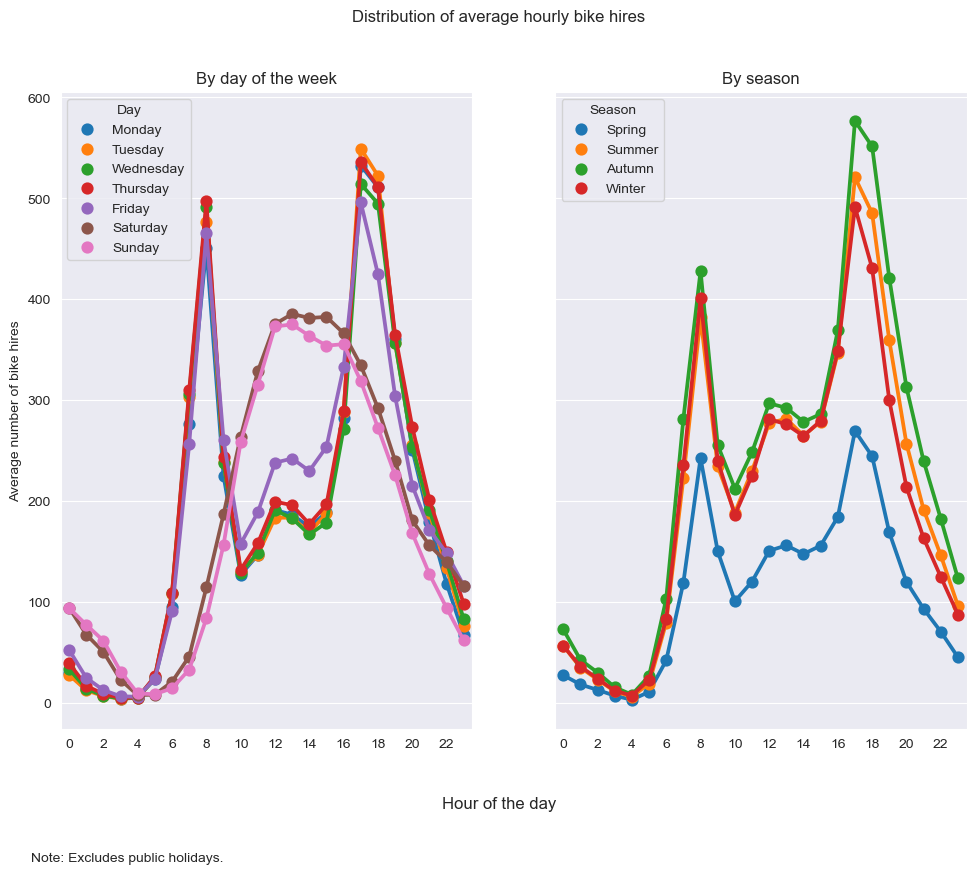

In [8]:
fig, (ax0, ax1)= plt.subplots(ncols=2, figsize=(11.69,8.27), sharex=True, sharey=True)
## PLOT BY HOUR

# Fixing weekday mapping
week_day_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
hour_data['day'] = hour_data.weekday.map(week_day_map)

# Plotting by hour - by weekday
sns.pointplot(data=hour_data[['hr', 'cnt','day']][hour_data.holiday==0],
              x='hr',
              y='cnt',
              hue='day',
              hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
              errorbar=None,
              ax=ax0)
ax0.set(title="By day of the week")
ax0.set_ylabel('Average number of bike hires')
ax0.set_xlabel(None)
ax0.legend(title = 'Day')
ax0.grid(visible=True, axis = 'y')
ax0.set_xticks(ticks = [i for i in range(0,24,2)])

# Mapping seasons
s_map = {1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'}
hour_data['season_name'] = hour_data.season.map(s_map)

## PLOT BY SEASON
sns.pointplot(data=hour_data[['hr', 'cnt','season_name']][hour_data.holiday==0],
              x='hr',
              y='cnt',
              hue='season_name',
              hue_order=['Spring', 'Summer', 'Autumn', 'Winter'],
              errorbar=None,
              ax=ax1)
ax1.set(title="By season")
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.legend(title = 'Season')
ax1.grid(visible=True, axis = 'y')
ax1.set_xticks(ticks = [i for i in range(0,24,2)])

# Overall plot attributes
plt.figtext(0.1, -0.05, "Note: Excludes public holidays.")
fig.supxlabel("Hour of the day")
fig.suptitle('Distribution of average hourly bike hires')
fig.savefig('plots/Hourly distribution charts.png')

## Statistical Tests
Chi Squared Test

In [9]:
# Init dataframe
df_bins = pd.DataFrame()
spring = day_data[day_data.season==1]['cnt'].values
summer = day_data[day_data.season==2]['cnt'].values

# Generate bins from control group
_, bins = pd.qcut(spring, q=16, retbins=True)
df_bins['bin'] = pd.cut(spring, bins=bins).value_counts().index

# Apply bins to both groups
df_bins['cnt_spring_observed'] = pd.cut(spring, bins=bins).value_counts().values
df_bins['cnt_summer_observed'] = pd.cut(summer, bins=bins).value_counts().values

# Compute expected frequency in the treatment group
df_bins['cnt_summer_expected'] = df_bins['cnt_spring_observed'] / np.sum(df_bins['cnt_spring_observed']) * np.sum(df_bins['cnt_summer_observed'])

df_bins

,bin,cnt_spring_observed,cnt_summer_observed,cnt_summer_expected
0,"(431.0, 982.0]",11,1,11.061111
1,"(982.0, 1164.5]",11,1,11.061111
2,"(1164.5, 1413.5]",11,0,11.061111
3,"(1413.5, 1538.0]",12,2,12.066667
4,"(1538.0, 1690.75]",11,2,11.061111
5,"(1690.75, 1861.5]",11,2,11.061111
6,"(1861.5, 2030.75]",11,2,11.061111
7,"(2030.75, 2209.0]",12,4,12.066667
8,"(2209.0, 2441.75]",11,4,11.061111
9,"(2441.75, 2879.5]",11,6,11.061111


In [10]:
from scipy.stats import chisquare

stat, p_value = chisquare(df_bins['cnt_summer_observed'], df_bins['cnt_summer_expected'])
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.10f}")

Chi-squared Test: statistic=622.8071, p-value=0.0000000000


Anderson-Darling Test for two samples

In [11]:
from scipy.stats import anderson_ksamp
statistic, crit, p = anderson_ksamp([spring,summer])
print(p)

0.001


C:\Users\roryc\AppData\Local\Temp\ipykernel_18484\2475551799.py:2: UserWarning: p-value floored: true value smaller than 0.001
  statistic, crit, p = anderson_ksamp([spring,summer])
